In [ ]:
import torch
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:
import torch.nn as nn

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
uNet = UNet(1)
model_path = '/content/drive/MyDrive/Colab Notebooks/model_checkpoints/uNet.th2024-06-02 23:26:10.232370'
uNet.load_state_dict(torch.load(model_path))
uNet.to(device)
uNet.eval()

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [ ]:
%cd /content/drive/MyDrive/ColabDataSets

/content/drive/MyDrive/ColabDataSets


In [ ]:
%cd /content/drive/MyDrive/ColabDataSets/EuroSAT_RGB

/content/drive/MyDrive/ColabDataSets/EuroSAT_RGB


In [ ]:
!ls -a

31_img.jpg  topdsm_2_12_selection-0001.jpg  topdsm30_selection-0001.jpg
35_img.jpg  topdsm28_selection-0001.jpg     topdsm_5_11_selection-0001.jpg


In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from glob import glob
from os import path
from PIL import Image

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, images_path, transform=None):
        self.images_path = images_path
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.images = []
        self.masks = []
        for im_f in glob(path.join(images_path, '*.jpg')):
            self.images.append(im_f)
        self.images.sort()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        box = (0, 0, 256, 256) # only used in inria
        image = image.crop(box)

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
inria = CustomDataset(r'Inria')

In [ ]:
inria_loader = torch.utils.data.DataLoader(inria, batch_size=1, shuffle=True)

torch.Size([3, 256, 256])


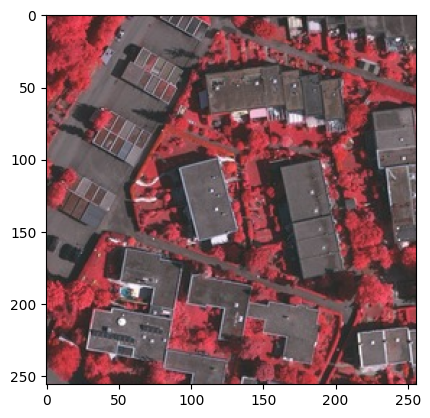

In [ ]:
# prompt: visualize the image in inria_loader

import matplotlib.pyplot as plt

for i, data in enumerate(inria_loader):

  plt.imshow(data[0].permute(1, 2, 0).cpu())
  print(data[0].shape)
  plt.show()
  break




In [ ]:
forest = CustomDataset(r'Forest')
inndustrial = CustomDataset(r'Industrial')
residential = CustomDataset(r'Residential')
highway = CustomDataset(r'Highway')
seaLake = CustomDataset(r'SeaLake')
herbaceousVegetation = CustomDataset(r'HerbaceousVegetation')

In [ ]:
forest_loader = torch.utils.data.DataLoader(forest, batch_size=1, shuffle=True)
industrial_loader = torch.utils.data.DataLoader(inndustrial, batch_size=1, shuffle=True)
residential_loader = torch.utils.data.DataLoader(residential, batch_size=1, shuffle=True)
highway_loader = torch.utils.data.DataLoader(highway, batch_size=1, shuffle=True)
seaLake_loader = torch.utils.data.DataLoader(seaLake, batch_size=1, shuffle=True)
herbaceousVegetation_loader = torch.utils.data.DataLoader(herbaceousVegetation, batch_size=1, shuffle=True)

In [ ]:
def visual_test_unseen_dataset(test_loader):
  import matplotlib.pyplot as plt
  from torch import nn
  with torch.no_grad():
    for i, data in enumerate(test_loader):
      if i == 1:
        break
      inputs = data
      inputs = inputs.to(device)
      outputs = uNet(inputs)

      # Visualize the results
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.imshow(inputs[0].permute(1, 2, 0).cpu())
      ax2.imshow(outputs[0].sigmoid().permute(1, 2, 0).cpu())
      plt.show()

In [ ]:
label_map = [
               (0, 0, 0),  # background
               (128, 0, 0), # aeroplane
               (0, 128, 0), # bicycle
               (128, 128, 0), # bird
               (0, 0, 128), # boat
               (128, 0, 128), # bottle
               (0, 128, 128), # bus
               (128, 128, 128), # car
               (64, 0, 0), # cat
               (192, 0, 0), # chair
               (64, 128, 0), # cow
               (192, 128, 0), # dining table
               (64, 0, 128), # dog
               (192, 0, 128), # horse
               (64, 128, 128), # motorbike
               (192, 128, 128), # person
               (0, 64, 0), # potted plant
               (128, 64, 0), # sheep
               (0, 192, 0), # sofa
               (128, 192, 0), # train
               (0, 64, 128) # tv/monitor
]

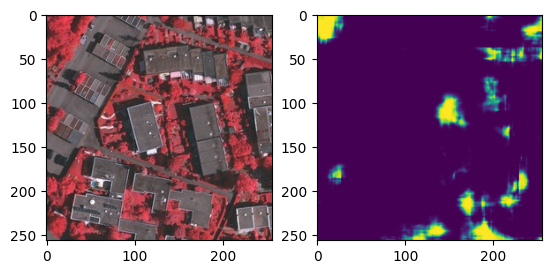

In [ ]:
visual_test_unseen_dataset(inria_loader)

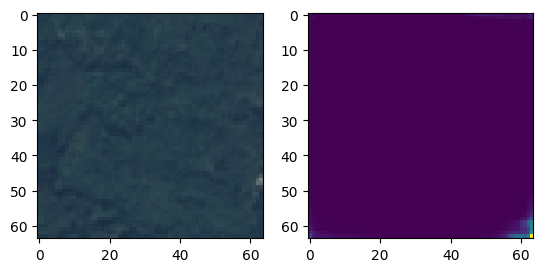

In [ ]:
visual_test_unseen_dataset(forest_loader)

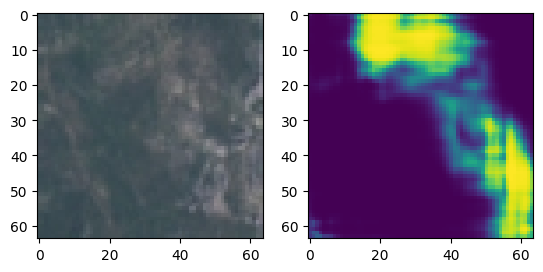

In [ ]:
visual_test_unseen_dataset(herbaceousVegetation_loader)

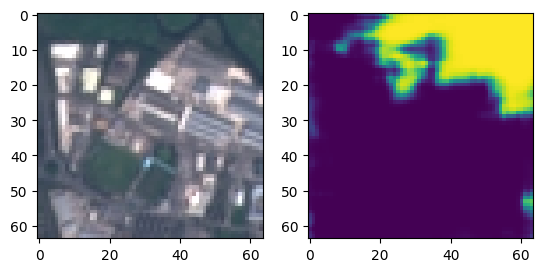

In [ ]:
visual_test_unseen_dataset(industrial_loader)

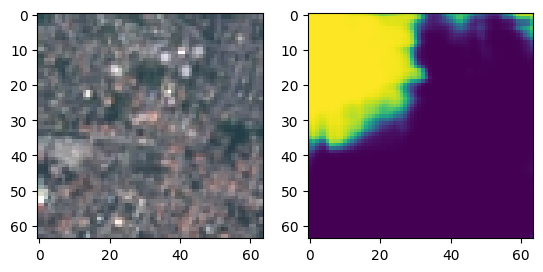

In [ ]:
visual_test_unseen_dataset(residential_loader)

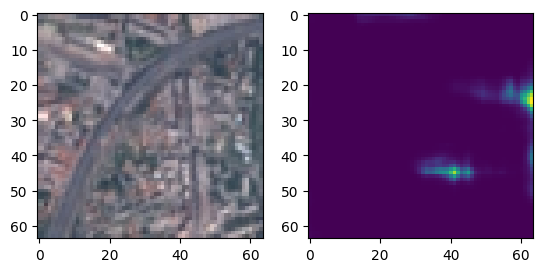

In [ ]:
visual_test_unseen_dataset(highway_loader)

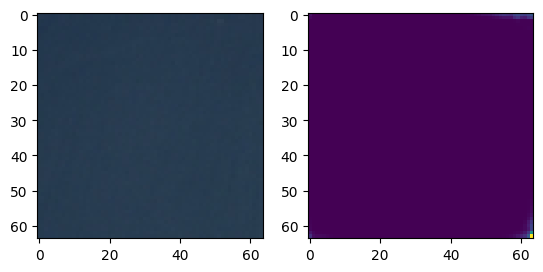

In [ ]:
visual_test_unseen_dataset(seaLake_loader)

In [ ]:
!pip install -U "ray[data,train,tune,serve]"

In [ ]:
from functools import partial
import os
import tempfile
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

In [ ]:
config = {
    "lr": tune.loguniform(0.0001, 0.01),
    "batch_size": tune.choice([2, 4, 8, 16]),
    "weight_decay": tune.loguniform(0.00001, 0.1)
}

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from glob import glob
from os import path

class CustomDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.images = []
        self.masks = []
        for im_f in glob(path.join(images_path, '*.jpg')):
            self.images.append(im_f)
        for im_f in glob(path.join(masks_path, '*.jpg')):
            self.masks.append(im_f)
        self.images.sort()
        self.masks.sort()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx]).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [ ]:
dataset = CustomDataset(images_path=r'/content/drive/MyDrive/ColabDataSets/ImageSegmented/images', masks_path=r'/content/drive/MyDrive/ColabDataSets/ImageSegmented/masks')

In [ ]:
from torch.utils.data import random_split, DataLoader
train_data, valid_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [ ]:
def train_optimization(config, data_dir=None):
    uNet_optim = UNet(1)
    uNet_optim = uNet_optim.to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(uNet_optim.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    start_epoch = 0

    train_loader = DataLoader(train_data, shuffle=True, batch_size=int(config["batch_size"]))
    valid_loader = DataLoader(valid_data, shuffle=True, batch_size=int(config["batch_size"]))

    for epoch in range(start_epoch, 10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = uNet_optim(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valid_loader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = uNet_optim(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": uNet.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report(
                {"loss": val_loss / val_steps, "accuracy": correct / total},
                checkpoint=checkpoint,
            )

    print("Finished Training")

In [ ]:
max_num_epochs = 5
num_samples = 5
data_dir = os.path.abspath("/content/drive/MyDrive/Colab Notebooks/model_optimization")
gpus_per_trial = 1

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2,
)

result = tune.run(
    partial(train_optimization, data_dir=data_dir),
    resources_per_trial={"cpu": 8, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
)

best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

2024-06-08 05:57:40,894	INFO worker.py:1744 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2024-06-08 05:57:41,817	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


+---------------------------------------------------------------------------+
| Configuration for experiment     train_optimization_2024-06-08_05-57-42   |
+---------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                    |
| Scheduler                        AsyncHyperBandScheduler                  |
| Number of trials                 5                                        |
+---------------------------------------------------------------------------+

View detailed results here: /root/ray_results/train_optimization_2024-06-08_05-57-42
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-06-08_05-57-38_405751_4773/artifacts/2024-06-08_05-57-42/train_optimization_2024-06-08_05-57-42/driver_artifacts`
(raylet) Warning: The actor ImplicitFunc is very large (61 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Ti

(func pid=14818) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00000_0_batch_size=2,lr=0.0037,weight_decay=0.0863_2024-06-08_05-57-43/checkpoint_000000)



Trial status: 1 RUNNING | 4 PENDING
Current time: 2024-06-08 08:15:19. Total running time: 2hr 17min 37s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status              lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00000   RUNNING    0.00374192               2      0.0863464          1            8240.78   0.668352      49169.5 |
| train_optimization_04d78_00001   PENDING    0.00016287               2      0.00274628                                                      |
| train_optimization_04d78_00002   PENDING    0.000777617             16      0.0427342          

(func pid=14818) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00000_0_batch_size=2,lr=0.0037,weight_decay=0.0863_2024-06-08_05-57-43/checkpoint_000001)



Trial status: 1 RUNNING | 4 PENDING
Current time: 2024-06-08 08:19:20. Total running time: 2hr 21min 37s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status              lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00000   RUNNING    0.00374192               2      0.0863464          2            8468.24   0.667964      49188.8 |
| train_optimization_04d78_00001   PENDING    0.00016287               2      0.00274628                                                      |
| train_optimization_04d78_00002   PENDING    0.000777617             16      0.0427342          

(func pid=14818) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00000_0_batch_size=2,lr=0.0037,weight_decay=0.0863_2024-06-08_05-57-43/checkpoint_000002)



Trial status: 1 RUNNING | 4 PENDING
Current time: 2024-06-08 08:22:50. Total running time: 2hr 25min 7s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status              lr     batch_size     weight_decay     iter     total time (s)      loss     accuracy |
+--------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00000   RUNNING    0.00374192               2      0.0863464          3            8696.99   0.66781      49158.2 |
| train_optimization_04d78_00001   PENDING    0.00016287               2      0.00274628                                                     |
| train_optimization_04d78_00002   PENDING    0.000777617             16      0.0427342                

(func pid=14818) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00000_0_batch_size=2,lr=0.0037,weight_decay=0.0863_2024-06-08_05-57-43/checkpoint_000003)



Trial status: 1 RUNNING | 4 PENDING
Current time: 2024-06-08 08:26:50. Total running time: 2hr 29min 8s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+---------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status              lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+---------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00000   RUNNING    0.00374192               2      0.0863464          4            8925.67   0.667721        49193 |
| train_optimization_04d78_00001   PENDING    0.00016287               2      0.00274628                                                      |
| train_optimization_04d78_00002   PENDING    0.000777617             16      0.0427342           

(func pid=14818) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00000_0_batch_size=2,lr=0.0037,weight_decay=0.0863_2024-06-08_05-57-43/checkpoint_000004)



Trial train_optimization_04d78_00001 started with configuration:
+---------------------------------------------------------+
| Trial train_optimization_04d78_00001 config             |
+---------------------------------------------------------+
| batch_size                                            2 |
| lr                                              0.00016 |
| weight_decay                                    0.00275 |
+---------------------------------------------------------+

Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-06-08 08:30:50. Total running time: 2hr 33min 8s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+------------------------

(func pid=53400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00001_1_batch_size=2,lr=0.0002,weight_decay=0.0027_2024-06-08_05-57-44/checkpoint_000000)



Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-06-08 08:34:20. Total running time: 2hr 36min 38s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00001   RUNNING      0.00016287               2      0.00274628         1            230.911   0.563675      49200.2 |
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5           9154.12    0.668811      49196.9 |
| train_optimization_04d78_00002   PENDING      0.000777617             

(func pid=53400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00001_1_batch_size=2,lr=0.0002,weight_decay=0.0027_2024-06-08_05-57-44/checkpoint_000001)



Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-06-08 08:38:21. Total running time: 2hr 40min 38s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00001   RUNNING      0.00016287               2      0.00274628         2            455.793   0.58846       49195.9 |
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5           9154.12    0.668811      49196.9 |
| train_optimization_04d78_00002   PENDING      0.000777617             

(func pid=53400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00001_1_batch_size=2,lr=0.0002,weight_decay=0.0027_2024-06-08_05-57-44/checkpoint_000002)



Trial train_optimization_04d78_00001 finished iteration 3 at 2024-06-08 08:41:51. Total running time: 2hr 44min 9s
+-------------------------------------------------------------------+
| Trial train_optimization_04d78_00001 result                       |
+-------------------------------------------------------------------+
| checkpoint_dir_name                             checkpoint_000002 |
| time_this_iter_s                                        226.36826 |
| time_total_s                                            682.16173 |
| training_iteration                                              3 |
| accuracy                                              49180.49363 |
| loss                                                      0.54485 |
+-------------------------------------------------------------------+
Trial train_optimization_04d78_00001 saved a checkpoint for iteration 3 at: (local)/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00001_1_batch_size=

(func pid=53400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00001_1_batch_size=2,lr=0.0002,weight_decay=0.0027_2024-06-08_05-57-44/checkpoint_000003)



Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-06-08 08:45:51. Total running time: 2hr 48min 9s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00001   RUNNING      0.00016287               2      0.00274628         4            909.831   0.524859      49139.7 |
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5           9154.12    0.668811      49196.9 |
| train_optimization_04d78_00002   PENDING      0.000777617             1

(func pid=53400) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00001_1_batch_size=2,lr=0.0002,weight_decay=0.0027_2024-06-08_05-57-44/checkpoint_000004)



Trial train_optimization_04d78_00002 started with configuration:
+---------------------------------------------------------+
| Trial train_optimization_04d78_00002 config             |
+---------------------------------------------------------+
| batch_size                                           16 |
| lr                                              0.00078 |
| weight_decay                                    0.04273 |
+---------------------------------------------------------+


(func pid=58282) /usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=58282)   return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-06-08 08:49:51. Total running time: 2hr 52min 9s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00002   RUNNING      0.000777617             16      0.0427342                                                       |
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5            9154.12   0.668811      49196.9 |
| train_optimization_04d78_00001   TERMINATED   0.00016287               

(func pid=58282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00002_2_batch_size=16,lr=0.0008,weight_decay=0.0427_2024-06-08_05-57-44/checkpoint_000000)



Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-06-08 08:53:21. Total running time: 2hr 55min 39s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00002   RUNNING      0.000777617             16      0.0427342          1            200.281   0.603003     392328   |
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5           9154.12    0.668811      49196.9 |
| train_optimization_04d78_00001   TERMINATED   0.00016287              

(func pid=58282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00002_2_batch_size=16,lr=0.0008,weight_decay=0.0427_2024-06-08_05-57-44/checkpoint_000001)



Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-06-08 08:56:22. Total running time: 2hr 58min 39s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00002   RUNNING      0.000777617             16      0.0427342          2            397.479   0.596399     392893   |
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5           9154.12    0.668811      49196.9 |
| train_optimization_04d78_00001   TERMINATED   0.00016287              

(func pid=58282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00002_2_batch_size=16,lr=0.0008,weight_decay=0.0427_2024-06-08_05-57-44/checkpoint_000002)



Trial status: 2 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-06-08 08:59:52. Total running time: 3hr 2min 9s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00002   RUNNING      0.000777617             16      0.0427342          3             593.27   0.599734     392450   |
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5            9154.12   0.668811      49196.9 |
| train_optimization_04d78_00001   TERMINATED   0.00016287               2

(func pid=58282) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00002_2_batch_size=16,lr=0.0008,weight_decay=0.0427_2024-06-08_05-57-44/checkpoint_000003)



Trial train_optimization_04d78_00003 started with configuration:
+---------------------------------------------------------+
| Trial train_optimization_04d78_00003 config             |
+---------------------------------------------------------+
| batch_size                                            4 |
| lr                                              0.00011 |
| weight_decay                                    0.00032 |
+---------------------------------------------------------+

Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-06-08 09:02:52. Total running time: 3hr 5min 9s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-------------------------

(func pid=61710) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00003_3_batch_size=4,lr=0.0001,weight_decay=0.0003_2024-06-08_05-57-44/checkpoint_000000)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-06-08 09:06:52. Total running time: 3hr 9min 10s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00003   RUNNING      0.000107064              4      0.000323017        1            231.933   0.535409      98219.4 |
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5           9154.12    0.668811      49196.9 |
| train_optimization_04d78_00001   TERMINATED   0.00016287               

(func pid=61710) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00003_3_batch_size=4,lr=0.0001,weight_decay=0.0003_2024-06-08_05-57-44/checkpoint_000001)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-06-08 09:10:52. Total running time: 3hr 13min 10s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00003   RUNNING      0.000107064              4      0.000323017        2            461.663   0.494275      98355.9 |
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5           9154.12    0.668811      49196.9 |
| train_optimization_04d78_00001   TERMINATED   0.00016287              

(func pid=61710) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00003_3_batch_size=4,lr=0.0001,weight_decay=0.0003_2024-06-08_05-57-44/checkpoint_000002)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-06-08 09:14:22. Total running time: 3hr 16min 40s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00003   RUNNING      0.000107064              4      0.000323017        3            689.937   0.485702      98328.3 |
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5           9154.12    0.668811      49196.9 |
| train_optimization_04d78_00001   TERMINATED   0.00016287              

(func pid=61710) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00003_3_batch_size=4,lr=0.0001,weight_decay=0.0003_2024-06-08_05-57-44/checkpoint_000003)



Trial status: 3 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-06-08 09:18:23. Total running time: 3hr 20min 40s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00003   RUNNING      0.000107064              4      0.000323017        4            917.703   0.499092      98390.9 |
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5           9154.12    0.668811      49196.9 |
| train_optimization_04d78_00001   TERMINATED   0.00016287              

(func pid=61710) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00003_3_batch_size=4,lr=0.0001,weight_decay=0.0003_2024-06-08_05-57-44/checkpoint_000004)



Trial status: 4 TERMINATED | 1 PENDING
Current time: 2024-06-08 09:21:53. Total running time: 3hr 24min 11s
Logical resource usage: 0/8 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5           9154.12    0.668811      49196.9 |
| train_optimization_04d78_00001   TERMINATED   0.00016287               2      0.00274628         5           1137.22    0.522534      49136.7 |
| train_optimization_04d78_00002   TERMINATED   0.000777617             16      0.042734

(func pid=66624) /usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
(func pid=66624)   return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Trial status: 4 TERMINATED | 1 RUNNING
Current time: 2024-06-08 09:22:23. Total running time: 3hr 24min 41s
Logical resource usage: 8.0/8 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                       status                lr     batch_size     weight_decay     iter     total time (s)       loss     accuracy |
+-----------------------------------------------------------------------------------------------------------------------------------------------+
| train_optimization_04d78_00004   RUNNING      0.0028245               16      0.0779196                                                       |
| train_optimization_04d78_00000   TERMINATED   0.00374192               2      0.0863464          5           9154.12    0.668811      49196.9 |
| train_optimization_04d78_00001   TERMINATED   0.00016287               2      0.00

(func pid=66624) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00004_4_batch_size=16,lr=0.0028,weight_decay=0.0779_2024-06-08_05-57-44/checkpoint_000000)
2024-06-08 09:25:16,967	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_optimization_2024-06-08_05-57-42' in 0.0056s.



Trial train_optimization_04d78_00004 finished iteration 1 at 2024-06-08 09:25:16. Total running time: 3hr 27min 34s
+-------------------------------------------------------------------+
| Trial train_optimization_04d78_00004 result                       |
+-------------------------------------------------------------------+
| checkpoint_dir_name                             checkpoint_000000 |
| time_this_iter_s                                        197.64207 |
| time_total_s                                            197.64207 |
| training_iteration                                              1 |
| accuracy                                             392327.73066 |
| loss                                                      0.66912 |
+-------------------------------------------------------------------+
Trial train_optimization_04d78_00004 saved a checkpoint for iteration 1 at: (local)/root/ray_results/train_optimization_2024-06-08_05-57-42/train_optimization_04d78_00004_4_batch_size